## In this notebook we explain our morphological postprocessing step that improved our score from 0.421 to 0.428 on LB

To see the full end-to-end pipeline go to https://github.com/neptune-ml/data-science-bowl-2018

In [59]:
%matplotlib inline

import os

import ipywidgets as ipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.externals import joblib

In [60]:
# masks, contours, ground_truth = joblib.load('../input/morphologicalpostprocessing/masks_contours_ground_truth_train.pkl')
masks, contours, ground_truth = joblib.load('/mnt/ml-team/minerva/dsb_2018_data/kaggle_kernels_data/masks_contours_ground_truth_train.pkl')

In [61]:
def plot_list(images, labels):
    n_img = len(images)
    n_lab = len(labels)
    n = n_lab+n_img
    plt.figure(figsize=(12,10))
    for i, image in enumerate(images):
        plt.subplot(1,n,i+1)
        plt.imshow(image)
    for j, label in enumerate(labels):
        plt.subplot(1,n,n_img+j+1)
        plt.imshow(label, cmap='nipy_spectral')
    plt.show()

Lets look at our **inputs**:
* maps
* contours

and **outputs**:
* ground truth

to get some intuition into what is possible

0


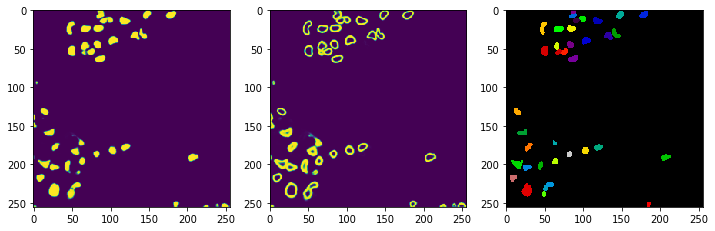

1


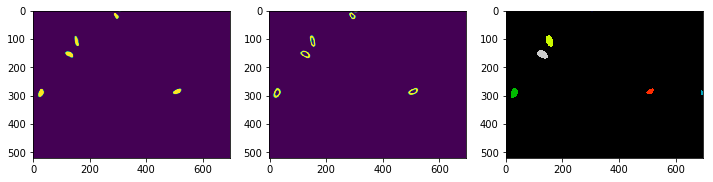

2


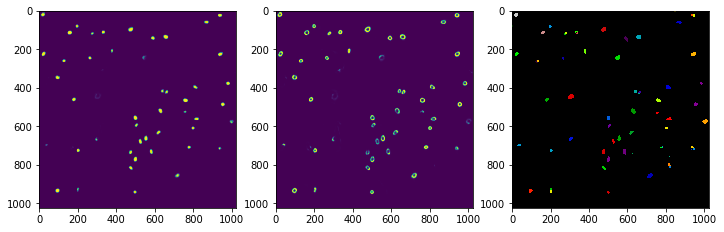

3


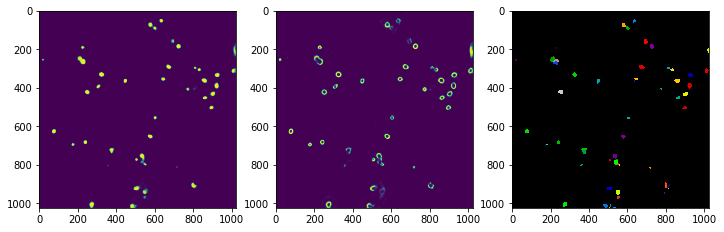

4


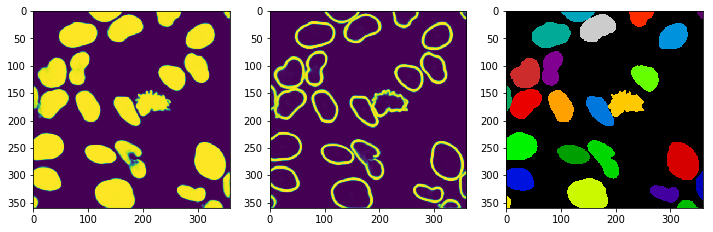

5


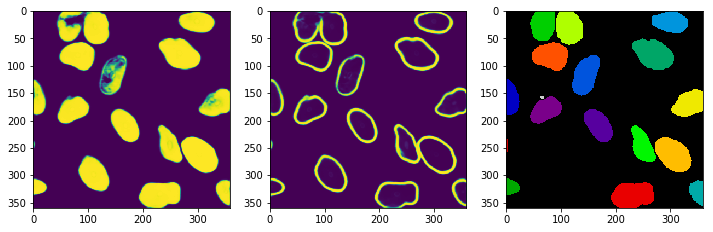

6


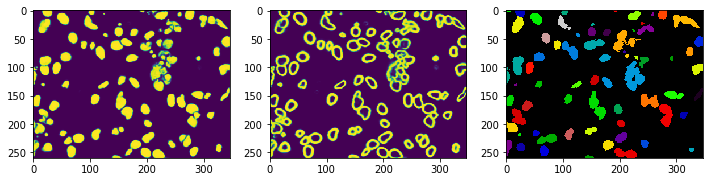

7


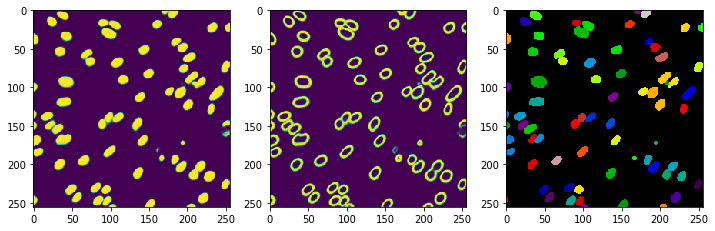

8


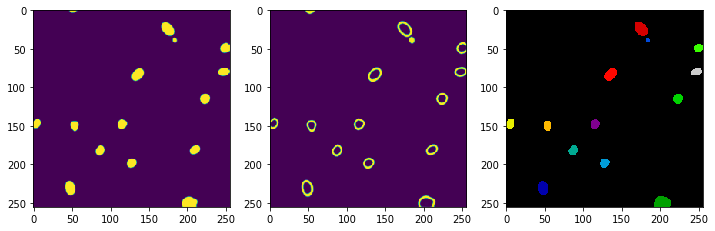

9


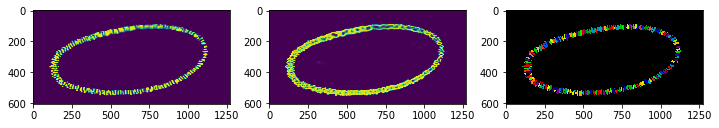

In [62]:
for idx in range(10):
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    gt = ground_truth[idx]
    
    plot_list(images = [mask,contour],labels = [gt])

Both masks and contours seem reasonably good and sometimes like in image 5 it is very beneficial to use both

# Plan:
We will use **marker based watershed** to detach nuclei and combine that with some **morphological** cleaning

If you don't know what it is check this link http://cmm.ensmp.fr/~beucher/wtshed.html

# What we need:
* Clean binary masks 
* Good nicely detached markers 
* Good distance 

# Clean Masks

## Problem 1 dirty masks

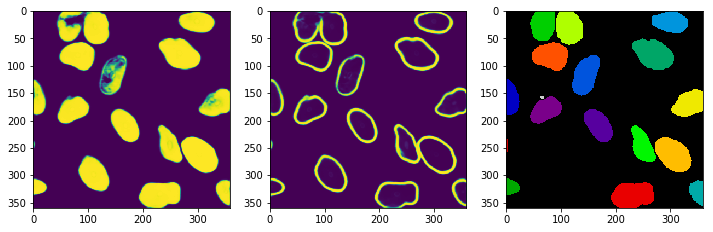

In [63]:
idx = 5
dirty = masks[idx], contours[idx], ground_truth[idx]

plot_list(images = [dirty[0],dirty[1]],
          labels = [dirty[2]])

## Problem 2 dirty at border

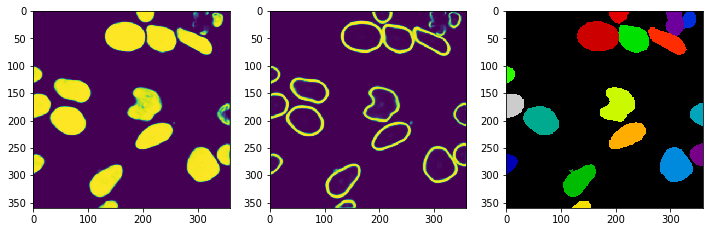

In [64]:
idx = 44
dirty_at_border = masks[idx], contours[idx], ground_truth[idx]

plot_list(images = [dirty_at_border[0],dirty_at_border[1]],
          labels = [dirty_at_border[2]])

We can immediately see that some of our cells are are **not very smooth** and there are **holes in them**.

Let's deal with that via morphological transformations. 
If it is the first time you hear about them it's a good moment to do some reading. 
Here is an interesting link https://homepages.inf.ed.ac.uk/rbf/HIPR2/morops.htm but there is a ton of stuff online so google it if you feel like it.

## Approach V1

In [65]:
import skimage.morphology as morph
from skimage.filters import threshold_otsu
import scipy.ndimage as ndi
from scipy.stats import itemfreq

Let's build a function that calculates the average size of the nuclei. We will need to to choose the structural element for our postprocessing

In [66]:
def mean_blob_size(mask):
    labels, labels_nr = ndi.label(mask)
    if labels_nr < 2:
        mean_area = 1
        mean_radius = 1
    else:
        mean_area = int(np.sqrt(itemfreq(labels)[1:, 1].mean()))
        mean_radius = int(np.round(np.sqrt(mean_area) / np.pi))
    return mean_area, mean_radius

Let's work on image 5

In [67]:
m, c, t = dirty

Now let's proceed to cleaning.

First we binarize both the mask and contours using global, otsu thresholding method:

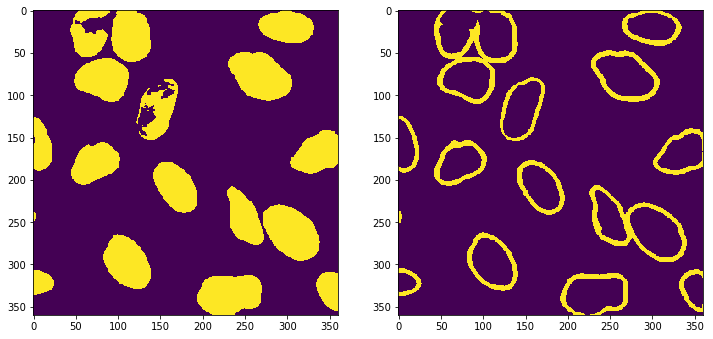

In [68]:
m_b = m > threshold_otsu(m)
c_b = c > threshold_otsu(c)

plot_list(images=[m_b,c_b],labels=[])

Then we go ahead and combine binarized masks and contours:

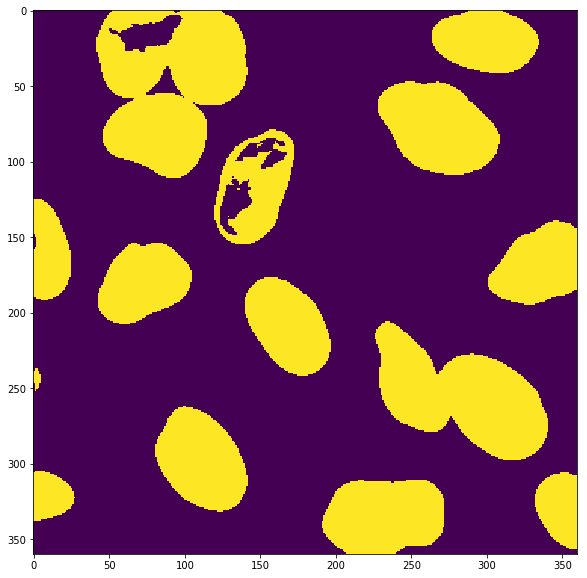

In [69]:
m_ = np.where(m_b | c_b, 1, 0)
plot_list(images=[m_],labels=[])

and fill the holes that remained

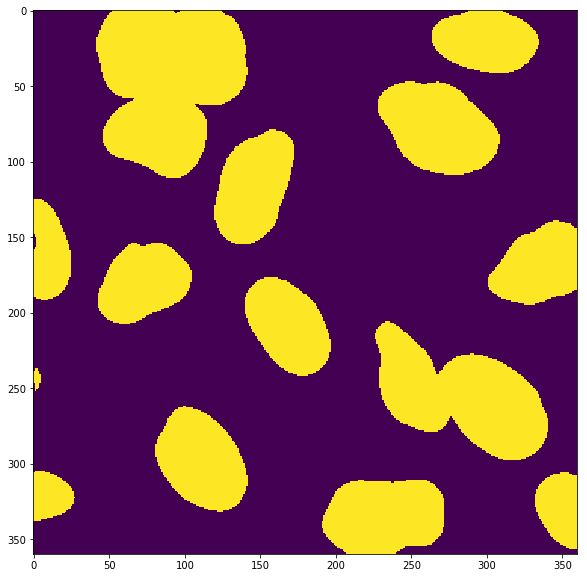

In [70]:
m_ = ndi.binary_fill_holes(m_)
plot_list(images=[m_],labels=[])

Now that we filled the holes in the cells we can detach them again because we have the contour information

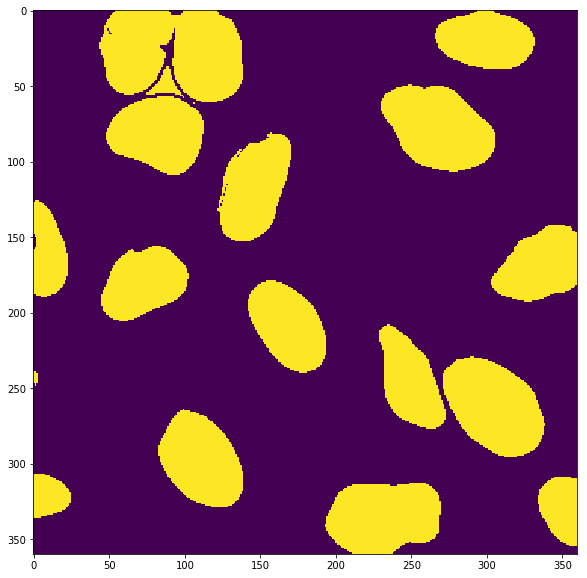

In [71]:
m_ = np.where(c_b & (~m_b), 0, m_)
plot_list(images=[m_],labels=[])

There is a problem with this approach. We are left with artifacts. Let's use binary_openning to drop them.

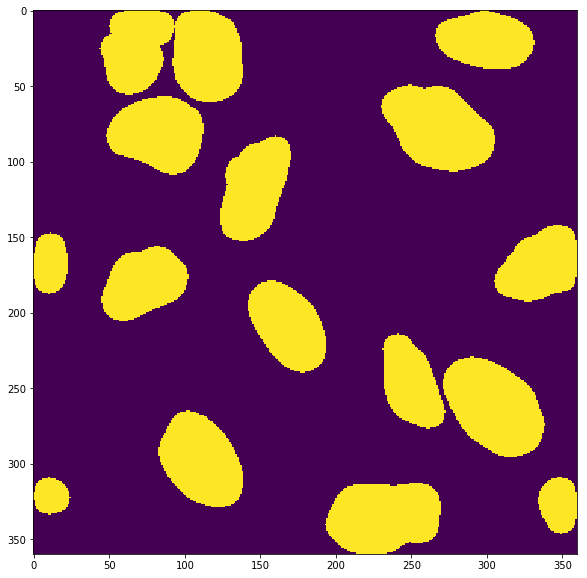

In [72]:
area, radius = mean_blob_size(m_b)
m_ = morph.binary_opening(m_, selem=morph.disk(0.25*area))
plot_list(images=[m_],labels=[])

Ok that looks fair.
Let's put it all together in a function

In [73]:
def clean_mask_v1(m,c):
    m_b = m > threshold_otsu(m)
    c_b = c > threshold_otsu(c)

    m_ = np.where(m_b | c_b, 1, 0)
    m_ = ndi.binary_fill_holes(m_)
    m_ = np.where(c_b & (~m_b), 0, m_)
    
    area, radius = mean_blob_size(m_b)
    m_ = morph.binary_opening(m_, selem=morph.disk(0.25*area))
    return m_

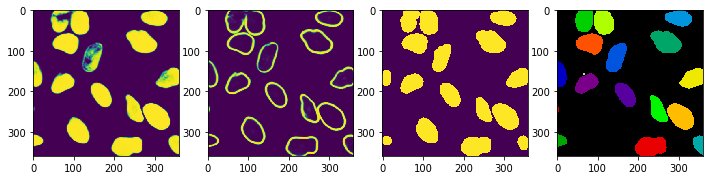

In [74]:
m, c, t = dirty

m_ = clean_mask_v1(m,c)

plot_list(images = [m,c,m_],
          labels = [t]
         )

It works to a certain extend but it removes things that where not connected and/or things around borders

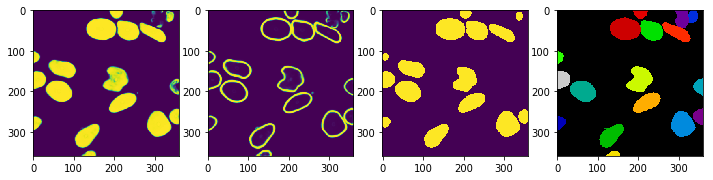

In [75]:
m,c,t = dirty_at_border
m_ = clean_mask_v1(m,c)

plot_list(images = [m,c,m_],
          labels = [t]
         )

## Approach V2

In [76]:
m,c,t = dirty_at_border

Let's start by binarizing and filling the holes again

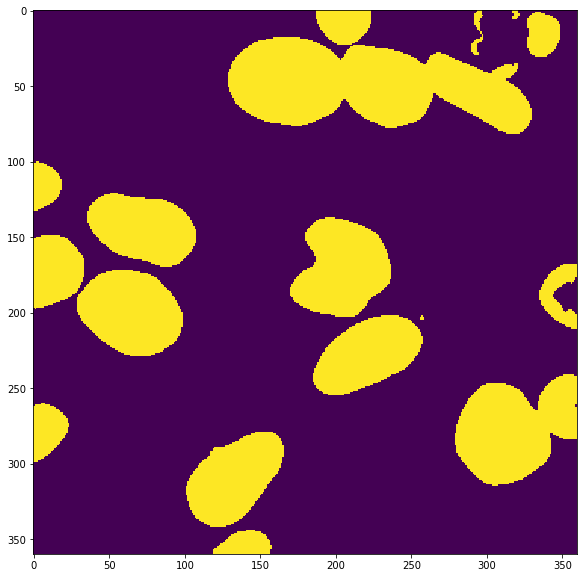

In [77]:
# threshold
m_b = m > threshold_otsu(m)
c_b = c > threshold_otsu(c)

# combine contours and masks and fill the cells
m_ = np.where(m_b | c_b, 1, 0)
m_ = ndi.binary_fill_holes(m_)
plot_list(images=[m_],labels=[])

Now we will use `binary_closing` to fill what wasn't closed with fill holes. We will need two helper functions `pad_mask` and `crop_mask` to deal with problems around the edges 

In [78]:
def pad_mask(mask, pad):
    if pad <= 1:
        pad = 2
    h, w = mask.shape
    h_pad = h + 2 * pad
    w_pad = w + 2 * pad
    mask_padded = np.zeros((h_pad, w_pad))
    mask_padded[pad:pad + h, pad:pad + w] = mask
    mask_padded[pad - 1, :] = 1
    mask_padded[pad + h + 1, :] = 1
    mask_padded[:, pad - 1] = 1
    mask_padded[:, pad + w + 1] = 1

    return mask_padded

def crop_mask(mask, crop):
    if crop == 1:
        crop = 2
    h, w = mask.shape
    mask_cropped = mask[crop:h - crop, crop:w - crop]
    return mask_cropped

ok lets go for it

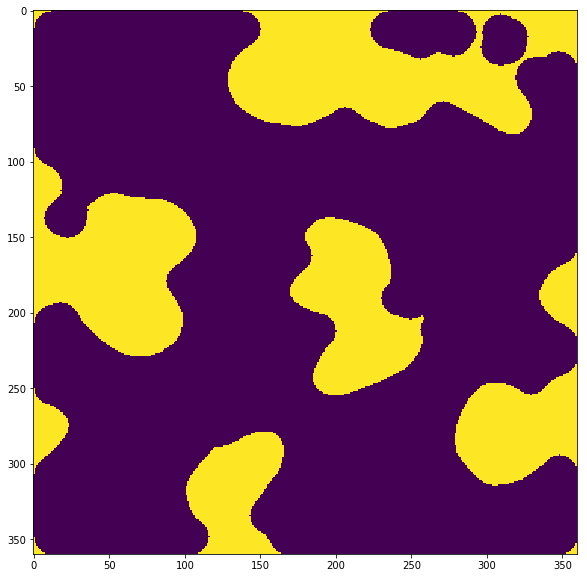

In [79]:
# close what wasn't closed before 
area, radius = mean_blob_size(m_b)
struct_size = int(6*radius)
struct_el = morph.disk(struct_size)
m_padded = pad_mask(m_, pad=struct_size)
m_padded = morph.binary_closing(m_padded, selem=struct_el)
m_ = crop_mask(m_padded, crop=struct_size)
plot_list(images=[m_],labels=[])

Yeah we closed everything but it is way more than we wanted. Let's now cut it with our contours and see what we get

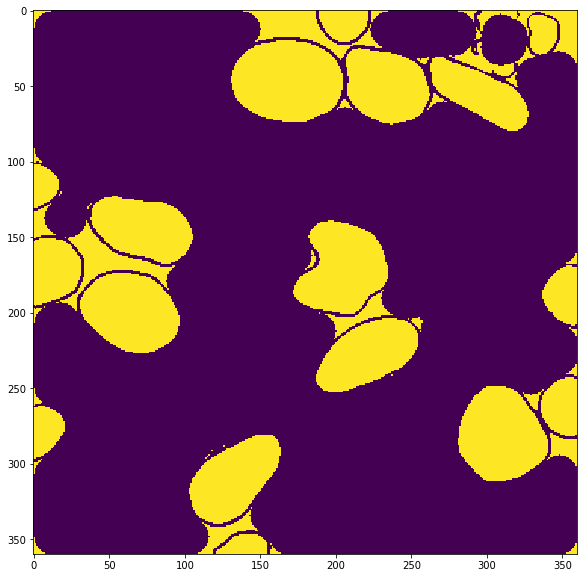

In [80]:
m_ = np.where(c_b & (~m_b), 0, m_)
plot_list(images=[m_],labels=[])

We got a lot of artifacts but we are getting places. If we could clean up those small artifacts we would be almost golden. Luckily we can use `binary_openning` with a larger structural element. Let's try that

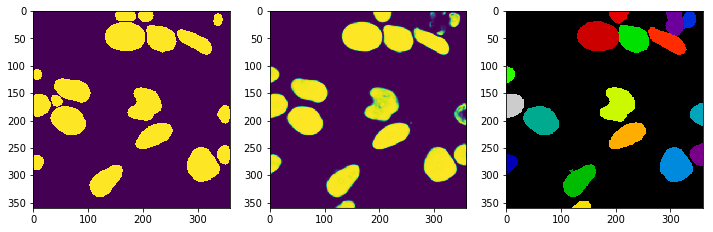

In [81]:
area, radius = mean_blob_size(m_b)
struct_size = int(4*radius)
struct_el = morph.disk(struct_size)
m_padded = pad_mask(m_, pad=struct_size)
m_padded = morph.binary_opening(m_padded, selem=struct_el)
m_ = crop_mask(m_padded, crop=struct_size)
plot_list(images=[m_,m],labels=[t])

Boom! It looks really nice. 

There are two problems with this result. First we have slightly smaller cells (like the blue one on the right edge) and we created some new cells (like the one at the top edge)!. Let's deal with it one problem at a time starting with the two small cell problem. We can simply join the result with the original binarized mask.

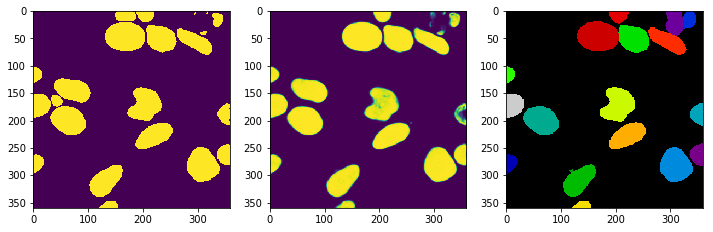

In [82]:
# join the connected cells with what we had at the beginning
m_ = np.where(m_b|m_,1,0)
m_ = ndi.binary_fill_holes(m_)
plot_list(images=[m_,m],labels=[t])

We'll deal with the second problem by going over all the resulting cells and calculating the coverage of the cell with the original binaraized image region. If nothing was there at the beginning nothing should be there now. Let's do that with the following `drop_artifacts` function

In [83]:
def drop_artifacts(mask_after, mask_pre, min_coverage=0.5):
    connected, nr_connected = ndi.label(mask_after)
    mask = np.zeros_like(mask_after)
    for i in range(1, nr_connected + 1):
        conn_blob = np.where(connected == i, 1, 0)
        initial_space = np.where(connected == i, mask_pre, 0)
        blob_size = np.sum(conn_blob)
        initial_blob_size = np.sum(initial_space)
        coverage = float(initial_blob_size) / float(blob_size)
        if coverage > min_coverage:
            mask = mask + conn_blob
        else:
            mask = mask + initial_space
    return mask



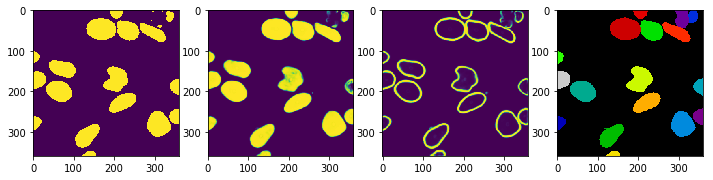

In [84]:
m_ = drop_artifacts(m_, m_b,min_coverage=0.25)
plot_list(images=[m_,m,c],labels=[t])

Not bad at all!

Let's put it all together in one function

In [85]:
def clean_mask_v2(m,c):
    # threshold
    m_b = m > threshold_otsu(m)
    c_b = c > threshold_otsu(c)

    # combine contours and masks and fill the cells
    m_ = np.where(m_b | c_b, 1, 0)
    m_ = ndi.binary_fill_holes(m_)

    # close what wasn't closed before 
    area, radius = mean_blob_size(m_b)
    struct_size = int(6*radius)
    struct_el = morph.disk(struct_size)
    m_padded = pad_mask(m_, pad=struct_size)
    m_padded = morph.binary_closing(m_padded, selem=struct_el)
    m_ = crop_mask(m_padded, crop=struct_size)
    
    # open to cut the real cells from the artifacts
    area, radius = mean_blob_size(m_b)
    struct_size = int(4*radius)
    struct_el = morph.disk(struct_size)
    m_ = np.where(c_b & (~m_b), 0, m_)
    m_padded = pad_mask(m_, pad=struct_size)
    m_padded = morph.binary_opening(m_padded, selem=struct_el)
    m_ = crop_mask(m_padded, crop=struct_size)

    # join the connected cells with what we had at the beginning
    m_ = np.where(m_b|m_,1,0)
    m_ = ndi.binary_fill_holes(m_)
    
    # drop all the cells that weren't present at least in 25% of area in the initial mask 
    m_ = drop_artifacts(m_, m_b,min_coverage=0.25)
    
    return m_

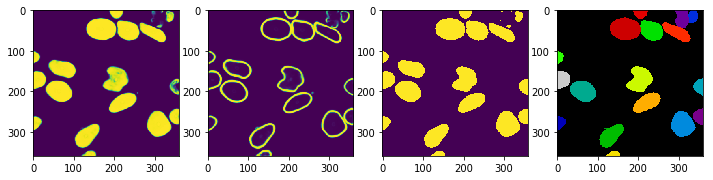

In [86]:
m,c,t = dirty_at_border
m_ = clean_mask_v2(m,c)

plot_list(images = [m,c,m_],
          labels = [t]
         )

0


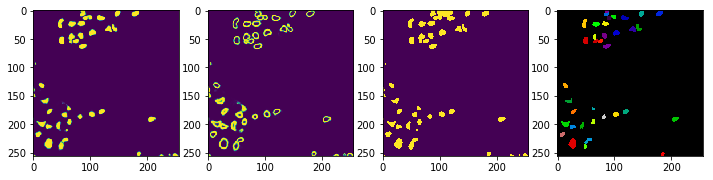

1


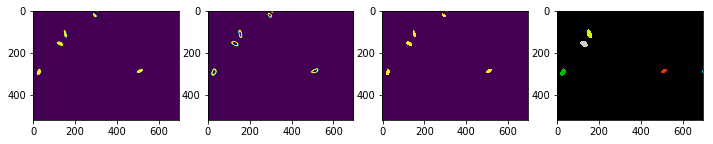

2


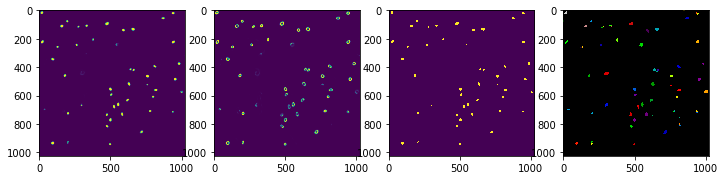

3


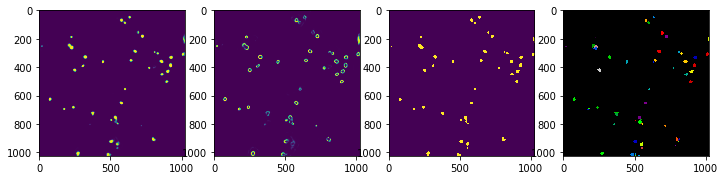

4


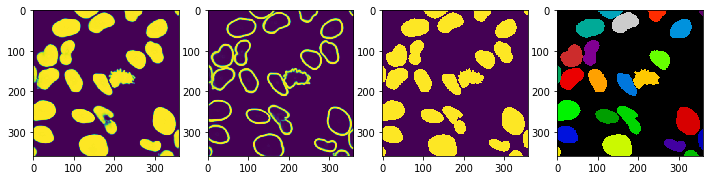

In [87]:
for idx in range(5):
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    gt = ground_truth[idx]
    
    plot_list(images = [mask,contour, cleaned_mask],labels = [gt])

It is still not perfect for instance the following problems still arise:

# Problem 3 not everything gets filled

38


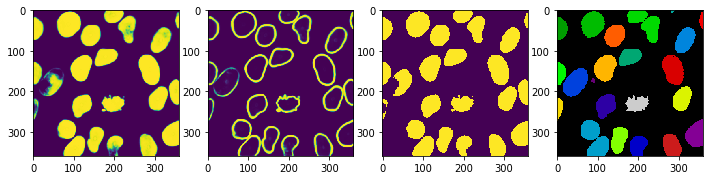

In [88]:
for idx in [38]:
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    gt = ground_truth[idx]
    
    plot_list(images = [mask,contour, cleaned_mask],labels = [gt])

Look at the blue cell on the yellow and blue cells on the left

# Problem 4 some cells get connected

0


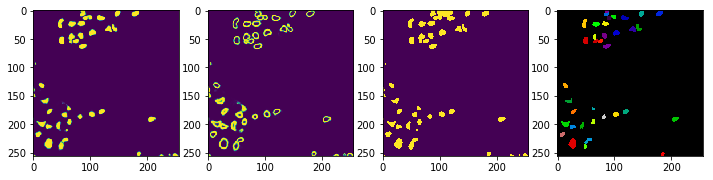

In [113]:
for idx in [0]:
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    gt = ground_truth[idx]
    
    plot_list(images = [mask,contour, cleaned_mask],labels = [gt])

Look at this large blob at the top. Also there are artifacts that aren't supposed to be there

# Ideas:
* work more with dilation
* do better around borders
* drop some cells after watershed with drop_artifact function

Go ahead and try to improve it. The floor is yours

In [90]:
def clean_mask_v3(m,c):
    return

# Good Markers

Let's now try end extract good markers for our watershed.

# Approach v1

In this approach we will simply cut the masks with the contours and use that as markers. Simple but really effective.

In [91]:
def good_markers_v1(m,c):
    # threshold
    m_b = m > threshold_otsu(m)
    c_b = c > threshold_otsu(c)
    
    mk_ = np.where(c_b,0,m)
    return mk_

0


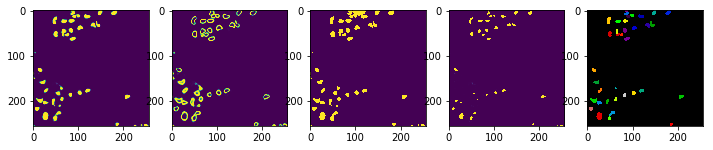

1


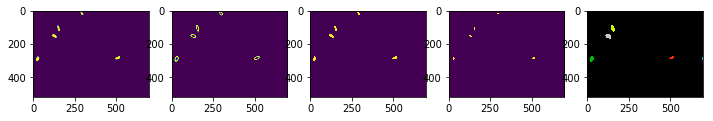

2


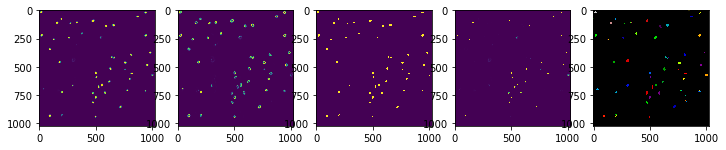

3


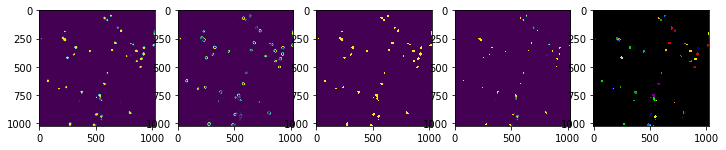

4


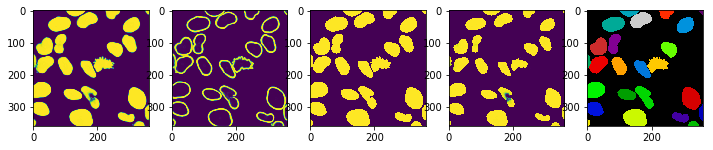

5


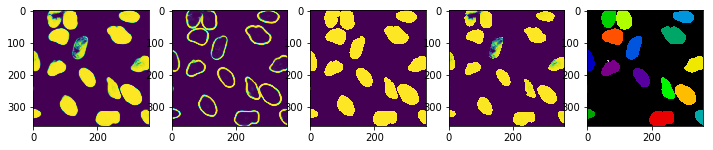

6


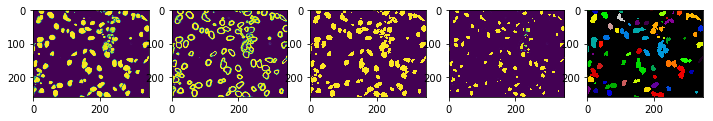

7


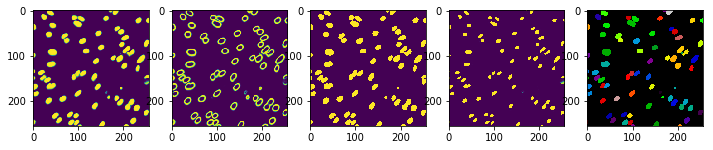

8


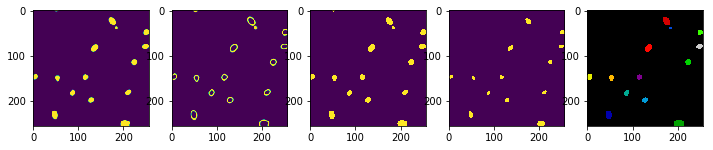

9


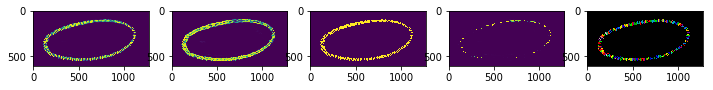

In [92]:
for idx in range(10):
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v1(mask,contour)
    gt = ground_truth[idx]
    
    plot_list(images = [mask,contour, cleaned_mask, good_markers],labels = [gt])

## Problem 1 building markers on initial mask when we have better mask

There is no point in using initial masks when we worked so hard on making them better right?

Let's use our results from the first step

In [93]:
def good_markers_v2(m_b,c):
    # threshold
    c_thresh = threshold_otsu(c)
    c_b = c > c_thresh
    
    mk_ = np.where(c_b,0,m_b)
    return mk_

0


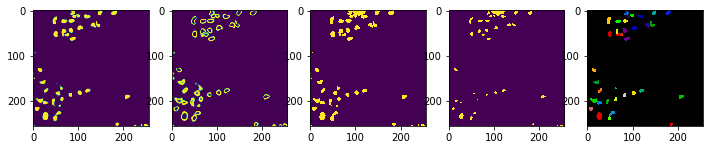

1


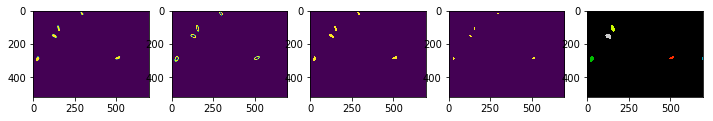

2


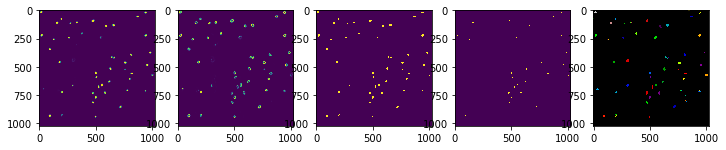

3


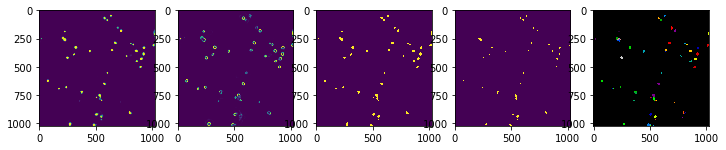

4


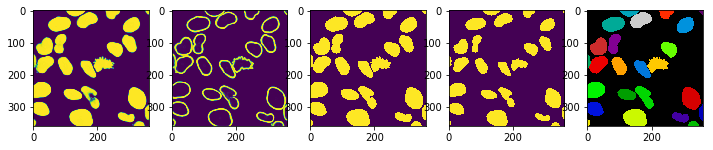

5


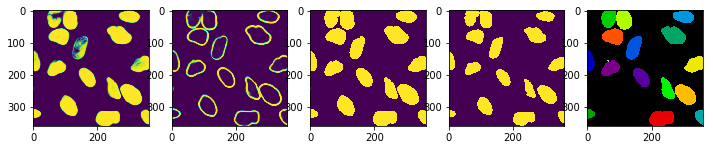

6


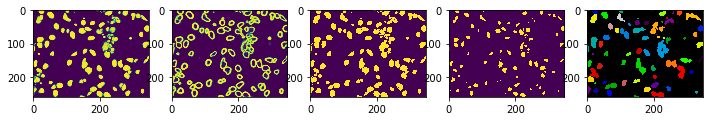

7


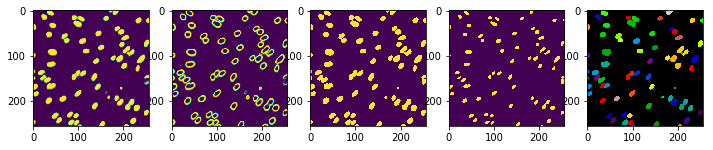

8


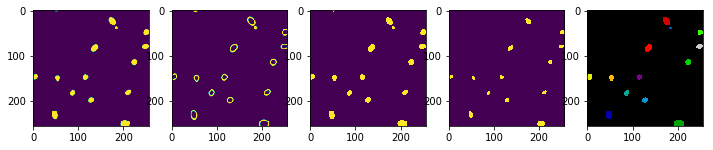

9


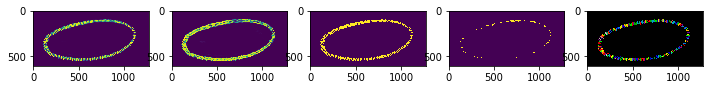

In [94]:
for idx in range(10):
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v2(cleaned_mask,contour)
    gt = ground_truth[idx]
    
    plot_list(images = [mask,contour, cleaned_mask, good_markers],labels = [gt])

## Problem 2 some markers are to large and connected

Unfortunately it is not perfect. If we have to connected cells and we have one connected marker for those cells watershed will not detach it. We need to make them better, smaller and positioned more in the center of nuceli.

In order to get there we can use `binary_erosion` 
Let's first do what we know

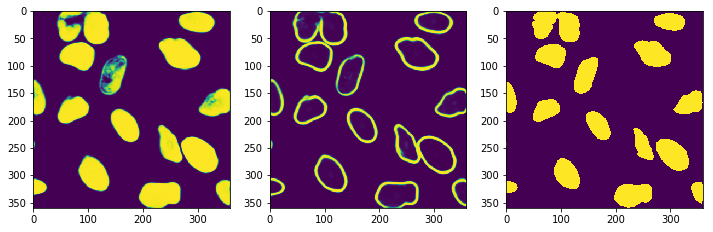

In [95]:
m,c,t = dirty

cleaned_mask = clean_mask_v2(m, c)

c_b = c > threshold_otsu(c)
mk_ = np.where(c_b,0,cleaned_mask)
plot_list(images=[m,c,mk_],labels=[])

For instance the two markers at the top left are still connected and will be treated as a single marker by the watershed. And nowe lets erode the markers

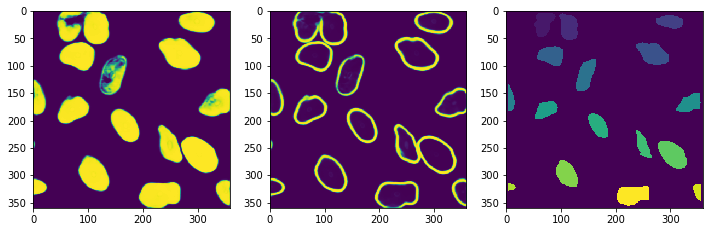

In [114]:
area, radius = mean_blob_size(m_b)
struct_size = int(radius)
struct_el = morph.disk(struct_size)
m_padded = pad_mask(mk_, pad=struct_size)
m_padded = morph.erosion(m_padded, selem=struct_el)
mk_ = crop_mask(m_padded, crop=struct_size)
plot_list(images=[m,c,mk_],labels=[])

ok thats not bad if we now compare those markers with the labels we get the following

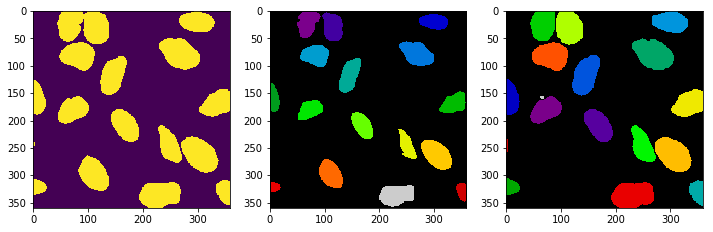

In [97]:
mk_,_ = ndi.label(mk_) 
plot_list(images=[cleaned_mask],labels=[mk_, t])

So the markers and cleaned mask look really good!

In [98]:
def good_markers_v3(m_b,c):
    # threshold
    c_b = c > threshold_otsu(c)
    
    mk_ = np.where(c_b,0,m_b)
    
    area, radius = mean_blob_size(m_b)
    struct_size = int(radius)
    struct_el = morph.disk(struct_size)
    m_padded = pad_mask(mk_, pad=struct_size)
    m_padded = morph.erosion(m_padded, selem=struct_el)
    mk_ = crop_mask(m_padded, crop=struct_size)
    mk_,_ = ndi.label(mk_) 
    return mk_

0


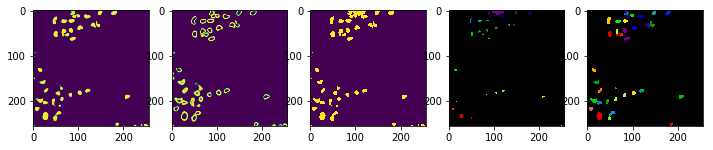

1


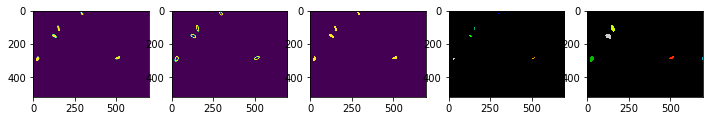

2


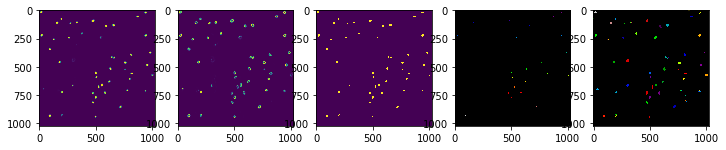

3


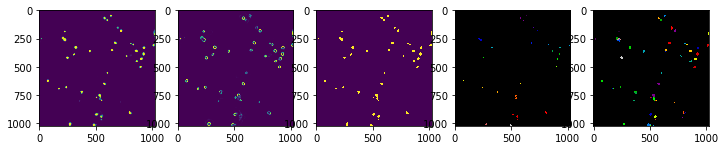

4


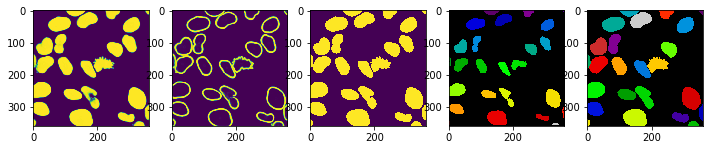

5


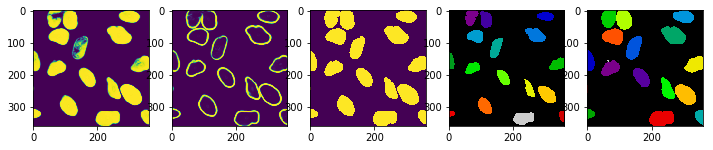

6


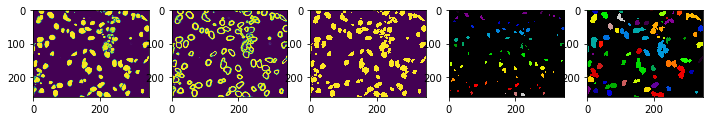

7


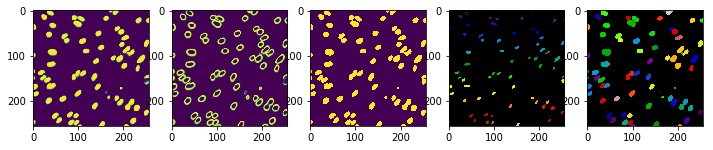

8


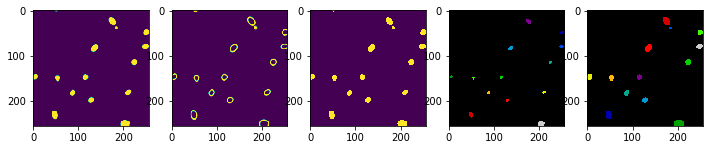

9


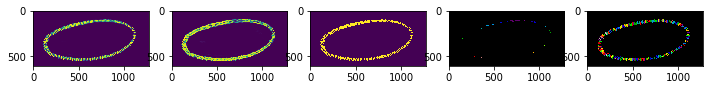

In [99]:
for idx in range(10):
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    gt = ground_truth[idx]
    
    plot_list(images = [mask,contour, cleaned_mask],labels = [good_markers, gt])

## Problem 3 still some barely connected markers are left

Unfortunately for some images the markers are not eroded enough and are left connected (look at the orange blob at the bottom right corner in the forth column).
Some tweaking should improve it but beware that for other images it might decrease the score.

25


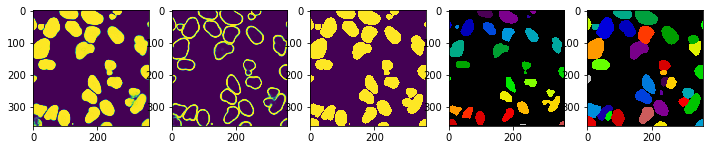

27


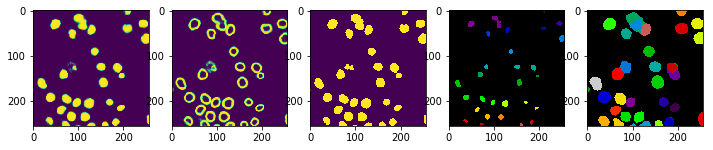

In [115]:
for idx in [25,27]:
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    gt = ground_truth[idx]
    
    plot_list(images = [mask,contour, cleaned_mask],labels = [good_markers, gt])

## Problem 4 we are dropping markers on many images with small cells

## Ideas
* play with binary closing/opening
* involve contours and/or centers in this
* we will asume that lost markers are in facet small cells that don't need to be divided and we will get back all the cells that were dropped in watershed
* use local maxima on distance transform

In [101]:
def good_markers_v4(m_b,c):
    return

# Good distance

Here I have no better idea than to use the binary distance from the background.
Feel free to improve on that!

In [102]:
def good_distance_v1(m_b):
    distance = ndi.distance_transform_edt(m_b)
    return distance

0


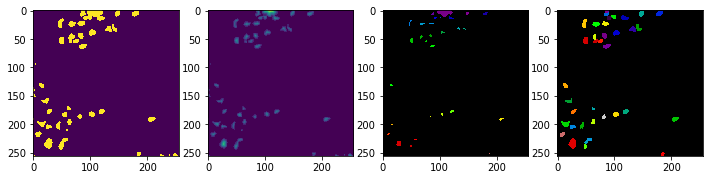

1


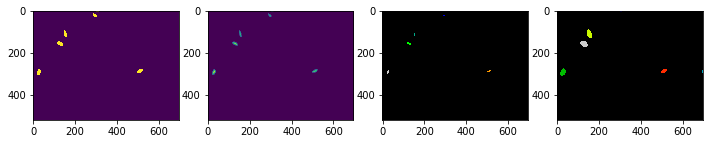

2


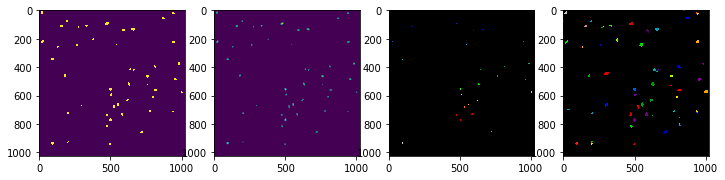

3


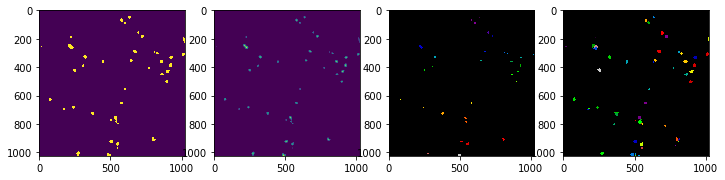

4


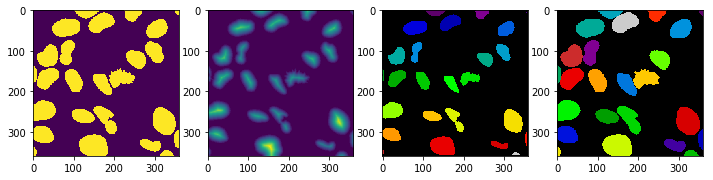

5


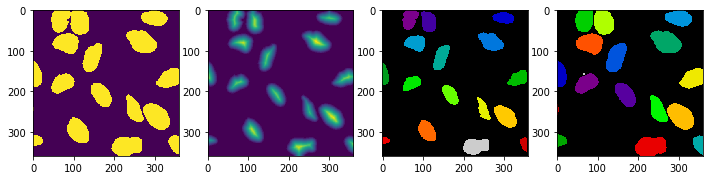

6


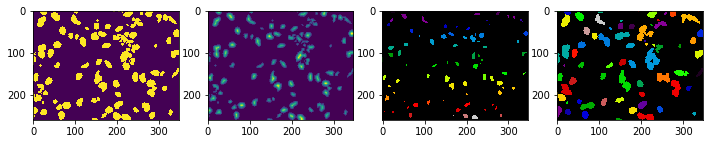

7


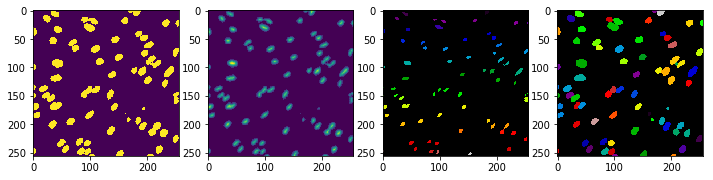

8


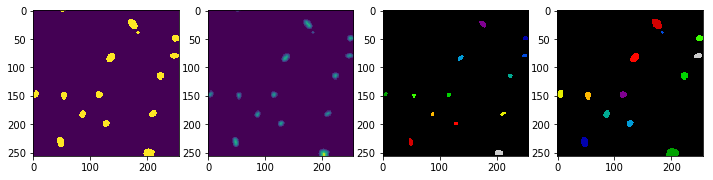

9


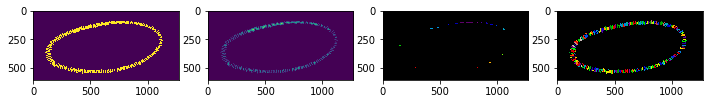

In [103]:
for idx in range(10):
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)
    gt = ground_truth[idx]
    
    plot_list(images = [cleaned_mask, good_distance],labels = [good_markers, gt])

## Idea
* investigate imposing some gradients on original image or good clean mask

## Watershed

Now that we have good masks, markersa and distance we can proceed to the watershed algorithm.

Let's try the simplest option without any tweaks

In [104]:
def watershed_v1(mask, contour):
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)
    
    water = morph.watershed(-good_distance, good_markers, mask=cleaned_mask)
    
    return water

0


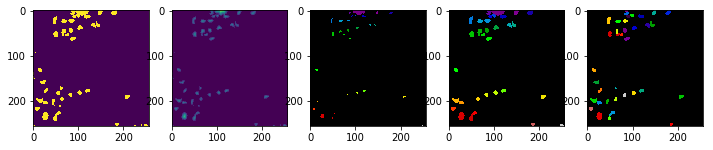

1


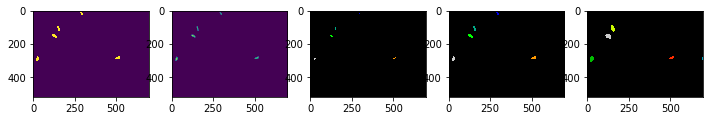

2


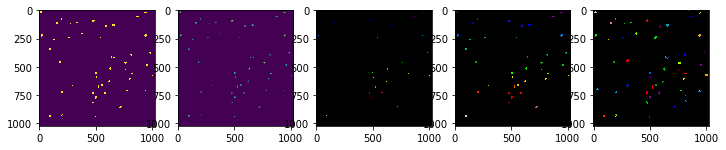

3


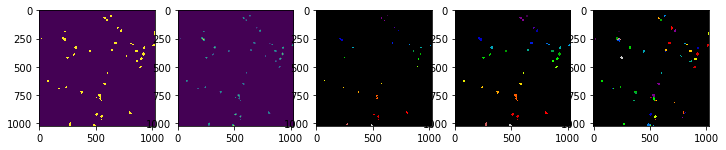

4


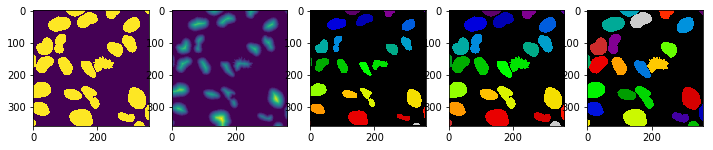

In [105]:
for idx in range(5):
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)
    
    water = watershed_v1(mask, contour)
    
    gt = ground_truth[idx]
    
    plot_list(images = [cleaned_mask, good_distance],labels = [good_markers, water,gt])

## Problem 1 some cells are dumped
## Problem 2 some artifacts from mask_cleaning remain

Unfortunatelly some cells are dropped, some cells are oversegmented and some artifacts from the mask cleaning still remain.

The good thing is we can deal with some of those problems by using ideas we have already tried. 

By the way do you know why the cells that are visible on the mask are sometimes dropped in the watershed?

I will not answer it know but simply solve it by adding the dropped cells to the output.

In [106]:
def add_dropped_water_blobs(water, mask_cleaned):
    water_mask = (water > 0).astype(np.uint8)
    dropped = mask_cleaned - water_mask
    dropped, _ = ndi.label(dropped)
    dropped = np.where(dropped, dropped + water.max(), 0)
    water = water + dropped
    return water

When it comes to artifacts left we will recycle the idea of dropping cells that weren't visible on the initial image.
Only difference is that now we need to iterate over connected components and apply drop artifacts to each component. 

Remember that some cells that are touching are detached by watershed.

In [107]:
def drop_artifacts_per_label(labels, initial_mask):
    labels_cleaned = np.zeros_like(labels)
    for i in `
        component = np.where(labels == i, 1, 0)
        component_initial_mask = np.where(labels == i, initial_mask, 0)
        component = drop_artifacts(component, component_initial_mask)
        labels_cleaned = labels_cleaned + component * i
    return labels_cleaned

Ok putting it all together gives us:

In [108]:
def watershed_v2(mask, contour):
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)
    
    water = morph.watershed(-good_distance, good_markers, mask=cleaned_mask)
    
    water = add_dropped_water_blobs(water, cleaned_mask)
    
    m_thresh = threshold_otsu(mask)
    initial_mask_binary = (mask > m_thresh).astype(np.uint8)
    water = drop_artifacts_per_label(water,initial_mask_binary)
    return water

0


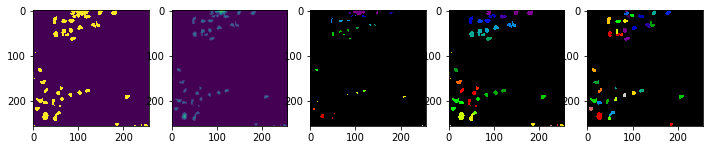

1


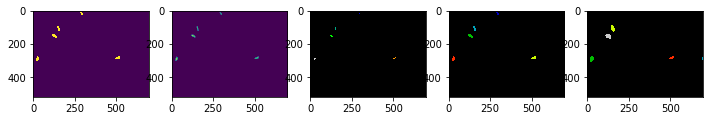

2


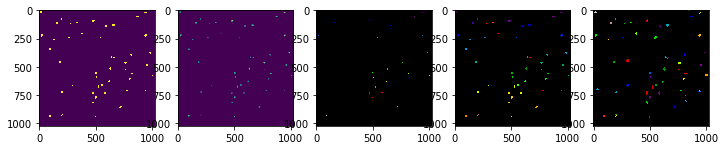

3


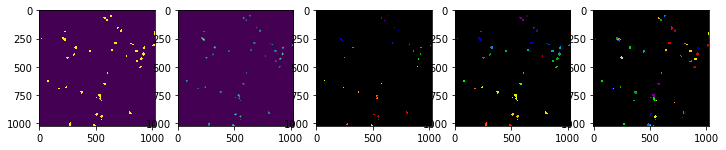

4


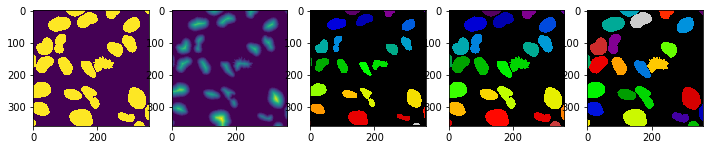

5


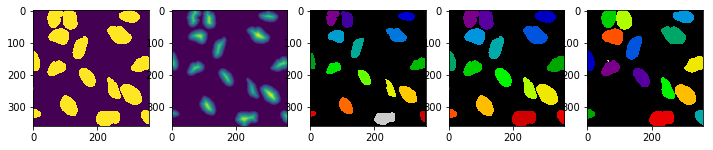

6


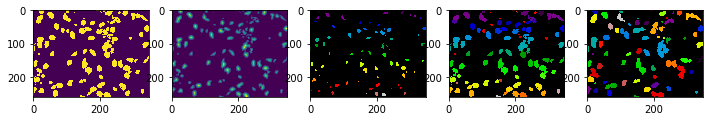

7


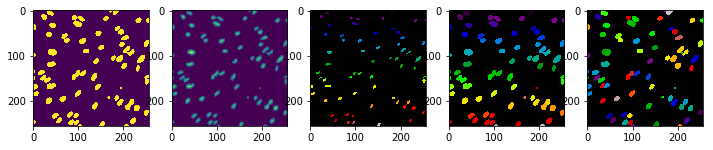

8


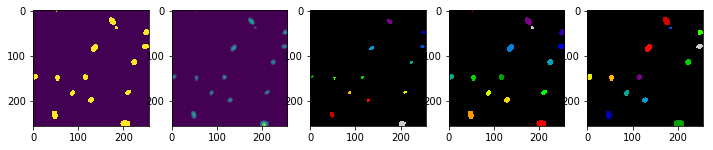

9


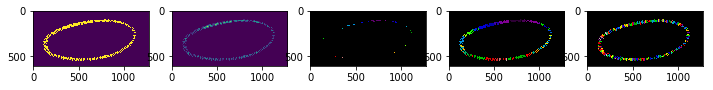

In [109]:
for idx in range(10):
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)
    
    water = watershed_v2(mask, contour)
    
    gt = ground_truth[idx]
    
    plot_list(images = [cleaned_mask, good_distance],labels = [good_markers, water,gt])

## Problem 3 some cells are oversemgmented and small cell chunks remain

Now some small pieces of cells may remain at this point or the cells could get oversegmented.
We will deal with that by dropping to small to be a cell blobs. However when we drop them and those oversegmentations happen in the middle of the cell we might end up with a hole. That is why we will iterate over every connected component and apply `binary_fill_hole` to it to remove that problem.

In [110]:
from itertools import product

def relabel(img):
    h, w = img.shape

    relabel_dict = {}

    for i, k in enumerate(np.unique(img)):
        if k == 0:
            relabel_dict[k] = 0
        else:
            relabel_dict[k] = i
    for i, j in product(range(h), range(w)):
        img[i, j] = relabel_dict[img[i, j]]
    return img

def drop_small(img, min_size):
    img = morph.remove_small_objects(img, min_size=min_size)
    return relabel(img)

def fill_holes_per_blob(image):
    image_cleaned = np.zeros_like(image)
    for i in range(1, image.max() + 1):
        mask = np.where(image == i, 1, 0)
        mask = ndi.morphology.binary_fill_holes(mask)
        image_cleaned = image_cleaned + mask * i
    return image_cleaned

In [111]:
def watershed_v3(mask, contour):
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)
    
    labels = morph.watershed(-good_distance, good_markers, mask=cleaned_mask)
    
    labels = add_dropped_water_blobs(labels, cleaned_mask)
    
    m_thresh = threshold_otsu(mask)
    initial_mask_binary = (mask > m_thresh).astype(np.uint8)
    labels = drop_artifacts_per_label(labels,initial_mask_binary)
    
    labels = drop_small(labels, min_size=20)
    labels = fill_holes_per_blob(labels)
        
    return labels

0


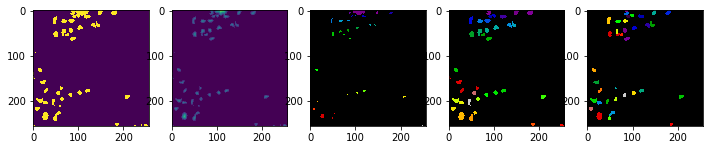

1


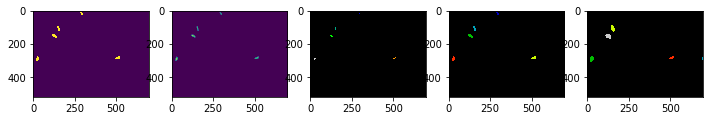

2


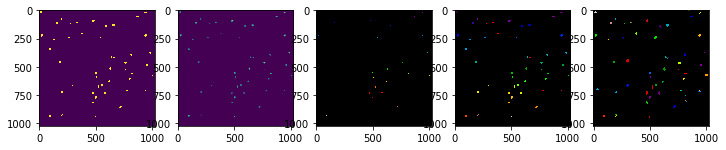

3


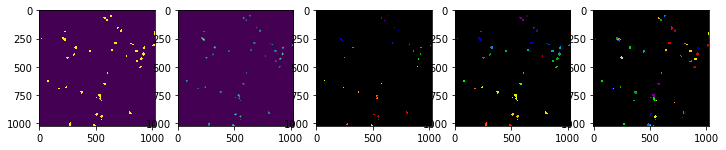

4


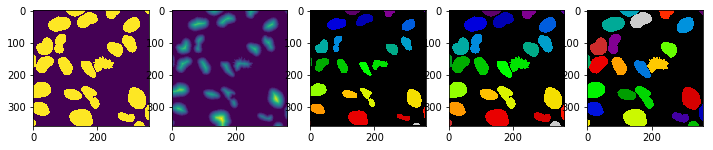

5


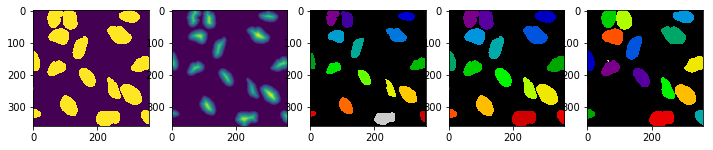

6


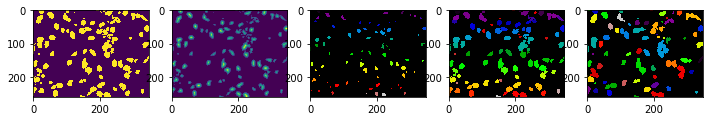

7


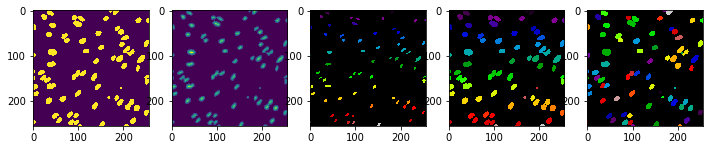

8


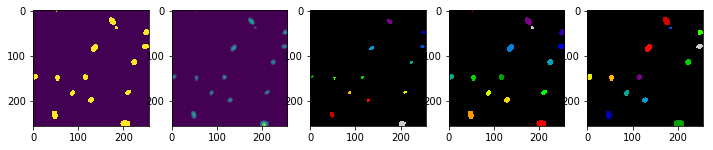

9


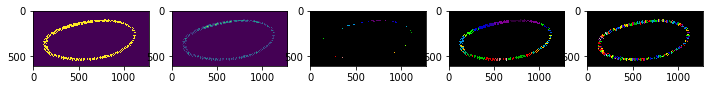

In [112]:
for idx in range(10):
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)
    
    water = watershed_v3(mask, contour)
    
    gt = ground_truth[idx]
    
    plot_list(images = [cleaned_mask, good_distance],labels = [good_markers, water,gt])

Voila! 

This solution works reasonably well. Of course there is still a lot of room for improvement.

For cells that get oversegmented we should implement a function that glues those oversegmented cells together rather than drop them. 

But that I will leave for you to create!

If you liked the solution and would like to see how it works as a part of the end-to-end pipeline please go to:

https://github.com/neptune-ml/data-science-bowl-2018

To stay up to date with new features and fully open sourced solution (with predictions) read our data science bowl journal thread https://www.kaggle.com/c/data-science-bowl-2018/discussion/47590 

Cheers and good luck!